In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-bright')

### Loading CSV

Load CSV and set index to datetime

In [2]:
from datetime import datetime

# Only selecting only relevant columns year (1), month (2), day (3), hour (4), pm2.5 (5), dewp (6), temp (7), pres (8), lws (10)
selected_column = ['year', 'month', 'day', 'hour', 'pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']

data = pd.read_csv('Haze.csv', parse_dates = [['year', 'month', 'day', 'hour']],\
                   date_parser = lambda x : datetime.strptime(x, '%Y %m %d %H'),\
                   usecols = selected_column)

# Rename columns
renamed_column = ['time', 'pm2_5', 'dewPoint', 'temp', 'pressure', 'wind_speed']
data.columns = renamed_column

# Set index as time
data.set_index('time', drop = True, inplace = True)

# Drop null value (first day)
data.dropna(axis = 0, inplace = True)

# Resampling to daily basis
data = data.resample('D').interpolate('time')

In [3]:
# Differencing 1 days to remove stationarity and to take the difference in reading
DIFF = 1
ydata = data.diff(periods = DIFF).dropna()

In [4]:
def create_data(timeseries):
    '''
    create_data : 
    
    Args:
        timeseries (numpy array) : 
    Return:
        x (numpy array) :
        y (numpy array) :
    ''' 
    # Squeeze timeseries to 1d array and turn timeseries from numpy array to Series
    timeseries = pd.Series(np.squeeze(timeseries))
    #timeseries = pd.Series(timeseries)
    # Create lookback as the target variable, y
    y = timeseries[LOOKBACK:]
    
    # With each iteration of lag, create its column
    X = pd.DataFrame({'lag'+str(LOOKBACK-i):timeseries.shift(-i) for i in range(0, LOOKBACK)}).dropna().iloc[:-1, :]
    
    return X, y

### LSTM Conditions : 7 lookback windows and 14 days in the testing set

In [5]:
TESTDAYS = 14
LOOKBACK = 7

In [6]:
from sklearn.preprocessing import MinMaxScaler

# Scale the features to range between -1 and 1
scaler = MinMaxScaler(feature_range = (-1, 1))
scaled = scaler.fit_transform(ydata['pm2_5'].values.reshape(-1, 1))

# Create data with 7 days lookback
X, y = create_data(scaled)

# Create a train and test set (30 days)
X_train, X_test = X[ : -TESTDAYS], X[-TESTDAYS : ]
y_train, y_test = y[ : -TESTDAYS], y[-TESTDAYS : ]

# Expand X_train, X_test dimension such that it can become batch_size, timestep (added dimension here), lookback window
X_train = np.expand_dims(X_train, axis = 1)
X_test = np.expand_dims(X_test, axis = 1)

In [7]:
def transform(scaled, org_arr, scaler, test = True):
    '''
    transform: taking the scaled array, apply inverse tranform and un-differencing it
    
    Args:
        scaled (numpy array) : predicted values
        org_arr (Series) : original series
        scaler (object)

    Return:
        result (Series) : overall series
        added (Series) : only transformed series
    '''

    #scaled = scaled[:, 0]
    scaled = scaler.inverse_transform(scaled)
    
    # Remove its dimension such that it is (n, ) and turn it into a Series
    scaled = pd.Series(scaled.squeeze())
    
    if test == True:
        # Adding the differenced array with the unscaled array, this resulting series will contain values from 1 to n
        added = pd.Series(org_arr[-(DIFF + TESTDAYS) : -DIFF].values + scaled)
        
        # Adding the first value of the original array to a new Series
        result = org_arr[: -(TESTDAYS)].append(added)
    else:
        # Adding the differenced array with the unscaled array, this resulting series will contain values from 1 to n
        added = pd.Series(org_arr[LOOKBACK : -(DIFF + TESTDAYS)].values + scaled)
        
        # Adding the first value of the original array to a new Series
        result = org_arr[: (DIFF + LOOKBACK)].append(added)

    # Reset index of result
    result.reset_index(drop = True, inplace = True)
    
    return result, added

### Using a Stateful 1 Layer LSTM model

In [8]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.callbacks import  TensorBoard, ModelCheckpoint

Using TensorFlow backend.


In [9]:
# Create Tensorboard for visualization
tensorboard = TensorBoard(log_dir = './logs')

# Create checkpoint that saves only best model
checkpoint = ModelCheckpoint('./checkpoints/stateful_lstm.hdf5', save_best_only = True)

# Create sequential layers
model = Sequential()

# Create 1 layer of LSTM with input shape of LOOKBACK (7 lags)
model.add(LSTM(4, stateful = True, batch_input_shape = (1, 1, LOOKBACK)))

# Add squashing function
model.add(Dense(1))

# Compile model with ADAM optimizer and with MSE as its loss
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_squared_error'])

# Iterate through 20 epochs, after each epoch reset its state
for i in range(20):
    # Fit model, the last cell state in a batch will be fed into the next cell state in the next batch 
    model.fit(X_train, y_train, batch_size = 1, epochs = 1, shuffle = False, \
            callbacks = [checkpoint, tensorboard], validation_data = (X_test, y_test))
    
    # Reset cell states so that cell state will be stable
    model.reset_states()

Train on 1803 samples, validate on 14 samples
Epoch 1/1
1803/1803 [==============================] - 10s - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0666 - val_mean_squared_error: 0.0666
Train on 1803 samples, validate on 14 samples
Epoch 1/1
1803/1803 [==============================] - 10s - loss: 0.0384 - mean_squared_error: 0.0384 - val_loss: 0.0563 - val_mean_squared_error: 0.0563
Train on 1803 samples, validate on 14 samples
Epoch 1/1
1803/1803 [==============================] - 10s - loss: 0.0356 - mean_squared_error: 0.0356 - val_loss: 0.0549 - val_mean_squared_error: 0.0549
Train on 1803 samples, validate on 14 samples
Epoch 1/1
1803/1803 [==============================] - 10s - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0548 - val_mean_squared_error: 0.0548
Train on 1803 samples, validate on 14 samples
Epoch 1/1
1803/1803 [==============================] - 12s - loss: 0.0343 - mean_squared_error: 0.0343 - val_loss: 0.0546 - val_mean_squared_error: 0.

In [10]:
# Get predicted data
y_pred = model.predict(X_test, batch_size = 1)

In [11]:
# Transform data back into undifferenced data
_, predicted = transform(y_pred, data['pm2_5'], scaler)

# Get index for plotting
predicted.index = data['pm2_5'][-TESTDAYS:].index

predicted

time
2014-12-18    -38.454216
2014-12-19     11.372726
2014-12-20     63.787735
2014-12-21      9.896865
2014-12-22      6.134306
2014-12-23     21.376669
2014-12-24    105.125565
2014-12-25     30.626833
2014-12-26     48.437927
2014-12-27     82.765985
2014-12-28    128.881191
2014-12-29    187.886841
2014-12-30    168.553375
2014-12-31    168.594736
Freq: D, dtype: float64

In [12]:
from sklearn.metrics import mean_squared_error

# Calculated root mean squared error of PM2.5 measurements
rmse = np.sqrt(mean_squared_error(data['pm2_5'][-TESTDAYS:].values, predicted))
rmse

140.14892469814481

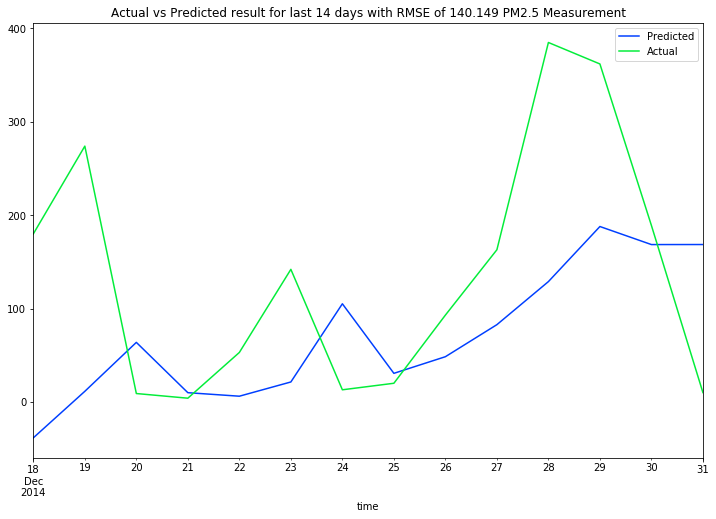

In [13]:
# Plot predicted vs actual

plt.figure(figsize = (12, 8))
plt.title('Actual vs Predicted result for last 14 days with RMSE of {:.3f} PM2.5 Measurement'.format(rmse))
predicted.plot(label = 'Predicted')
data['pm2_5'][-TESTDAYS:].plot(label = 'Actual')
plt.legend(loc = 'best')

### Stacked Stateful LSTM

In [15]:
# Create Tensorboard for visualization
tensorboard = TensorBoard(log_dir = './logs')

# Create checkpoint that saves only best model
checkpoint = ModelCheckpoint('./checkpoints/stateful_lstm.hdf5', save_best_only = True)

# Create sequential layers
model = Sequential()

# Create 1 layer of LSTM with input shape of LOOKBACK (7 lags)
model.add(LSTM(4, stateful = True, batch_input_shape = (1, 1, LOOKBACK)))

# Add squashing function
model.add(Dense(1))

# Compile model with ADAM optimizer and with MSE as its loss
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = ['mean_squared_error'])

# Iterate through 20 epochs, after each epoch reset its state
for i in range(20):
    # Fit model, the last cell state in a batch will be fed into the next cell state in the next batch 
    model.fit(X_train, y_train, batch_size = 1, epochs = 1, shuffle = False, \
            callbacks = [checkpoint, tensorboard], validation_data = (X_test, y_test))
    
    # Reset cell states so that cell state will be stable
    model.reset_states()

Train on 1803 samples, validate on 14 samples
Epoch 1/1
1803/1803 [==============================] - 9s - loss: 0.0464 - mean_squared_error: 0.0464 - val_loss: 0.0731 - val_mean_squared_error: 0.0731
Train on 1803 samples, validate on 14 samples
Epoch 1/1
1803/1803 [==============================] - 9s - loss: 0.0398 - mean_squared_error: 0.0398 - val_loss: 0.0648 - val_mean_squared_error: 0.0648
Train on 1803 samples, validate on 14 samples
Epoch 1/1
1803/1803 [==============================] - 11s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0608 - val_mean_squared_error: 0.0608
Train on 1803 samples, validate on 14 samples
Epoch 1/1
1803/1803 [==============================] - 9s - loss: 0.0357 - mean_squared_error: 0.0357 - val_loss: 0.0614 - val_mean_squared_error: 0.0614
Train on 1803 samples, validate on 14 samples
Epoch 1/1
1803/1803 [==============================] - 8s - loss: 0.0348 - mean_squared_error: 0.0348 - val_loss: 0.0592 - val_mean_squared_error: 0.0592

In [16]:
# Get predicted data
y_pred = model.predict(X_test, batch_size = 1)

In [17]:
# Transform data back into undifferenced data
_, predicted = transform(y_pred, data['pm2_5'], scaler)

# Get index for plotting
predicted.index = data['pm2_5'][-TESTDAYS:].index

predicted

time
2014-12-18     -1.362727
2014-12-19     56.506813
2014-12-20     95.905624
2014-12-21     20.466662
2014-12-22     -4.912903
2014-12-23     18.514095
2014-12-24     91.079491
2014-12-25     23.108134
2014-12-26     30.933358
2014-12-27     65.532681
2014-12-28    107.419262
2014-12-29    159.445908
2014-12-30    146.973083
2014-12-31    158.391991
Freq: D, dtype: float64

In [18]:
# Calculated root mean squared error of PM2.5 measurements
rmse = np.sqrt(mean_squared_error(data['pm2_5'][-TESTDAYS:].values, predicted))
rmse

138.34378026268249

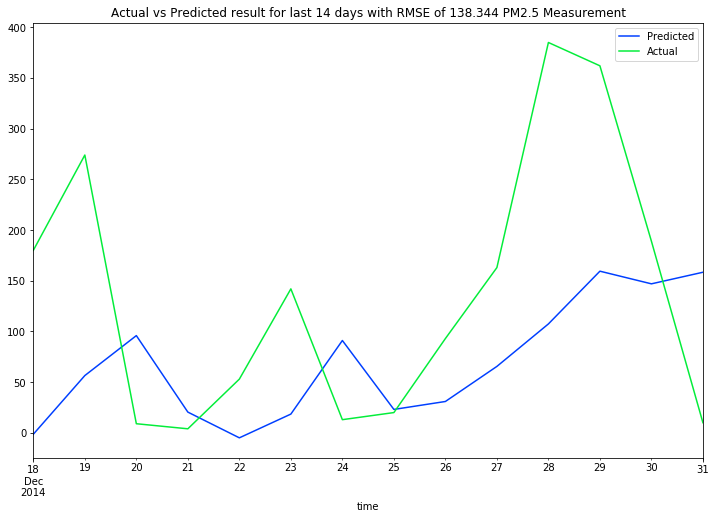

In [19]:
# Plot predicted vs actual

plt.figure(figsize = (12, 8))
plt.title('Actual vs Predicted result for last 14 days with RMSE of {:.3f} PM2.5 Measurement'.format(rmse))
predicted.plot(label = 'Predicted')
data['pm2_5'][-TESTDAYS:].plot(label = 'Actual')
plt.legend(loc = 'best')